<a href="https://colab.research.google.com/github/lscott-knighted/EZBacSim/blob/main/EZBacSim_Project_shadow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports: Random for shuffling, pandas for dataframes, time/tqdm for a useful
# progress bar during the number crunching. Seaborn for pretty graphs.
import random
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns

# Define cards, decks, shoes.
a = 1
j = q = k = 10
cards = ['a', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'j', 'q', 'k']
deck = cards * 4
shoe = deck * 8

# Define Burn Values
burn_vals = {
    'a': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    'j': 1,
    'q': 2,
    'k': 3
}

# Define banker hit matrix. By calling the matrix later of [banker hand value][player hit card value]
# we can determine whether or not the banker hand should be hitting.
banker_hit_matrix = [[1,1,1,1,1,1,1,1,1,1], #0 hits on everything
                    [1,1,1,1,1,1,1,1,1,1], # 1 hits on everything
                    [1,1,1,1,1,1,1,1,1,1], # 2 hits on everything
                    [1,1,1,1,1,1,1,1,0,1], # 3 hits on everything except an 8
                    [0,0,1,1,1,1,1,1,0,0], # 4 hits on 2-7
                    [0,0,0,0,1,1,1,1,0,0], # 5 hits on 4-7
                    [0,0,0,0,0,0,1,1,0,0], # 6 hits on 6 and 7
                    [0,0,0,0,0,0,0,0,0,0], # 7 doesn't hit
                    [0,0,0,0,0,0,0,0,0,0], # 8 doesn't hit
                    [0,0,0,0,0,0,0,0,0,0]] # 9 doesn't hit

# Build initial dataframe.
column_titles = ['Total Hands', 'Player Wins', 'Banker Wins', 'Pandas', 'Dragon', 'Ties', 'Longest Player Line', 'Longest Banker Line']
#df = pd.DataFrame(columns = column_titles)

In [ ]:
append_data = []
reps = 500000 # Define count of shoes to simulate.

# Deal each shoe as a run through this loop.
for i in tqdm(range(reps)):
    # Shuffle the shoe.
    random.shuffle(shoe)

    # Define starting values.
    longest_player_streak = 0
    longest_banker_streak = 0
    current_player_streak = 0
    current_banker_streak = 0
    player_win = 0
    banker_win = 0
    dragon = 0
    panda = 0
    tie = 0
    hands = 0
    p3 = '10'

    # We will navigate through the shoe by iterating an index within the shoe everytime we 'deal' a card.
    # This has the side effect that we could store the order of the shoe as a variable for analysis on
    # if dragons/pandas had some sort of correlation with weird shoe orders.
    idx_shoe = 0

    # Look at burn card, 'remove' cards from front accordingly.
    idx_shoe = idx_shoe + 1 + burn_vals[shoe[0]]

    # Burn between 1-2 decks from the back of the shoe by defining a 'maximum index' to halt the
    # dealing loop once we're past our 'cut card'.
    max_idx = len(shoe) - random.randint(52,104)

    # Deal out the hands of the shoe.
    while(idx_shoe < max_idx):
      # reset the player and banker_hit conditionals. These change when either player or banker side hits a 3rd card.
      player_hit = False
      banker_hit = False

      # deal the first four cards to player and banker sides, alternating between them, and then iterate over the idx of the shoe to the next card
      p1 = shoe[idx_shoe]
      idx_shoe+=1
      b1 = shoe[idx_shoe]
      idx_shoe+=1
      p2 = shoe[idx_shoe]
      idx_shoe+=1
      b2 = shoe[idx_shoe]
      idx_shoe+=1

      # calculate initial hand values. Has handy effect of resetting hand values from last hand as well.
      player_score = (eval(p1) + eval(p2))%10
      banker_score = (eval(b1) + eval(b2))%10

      # Naturals and natural ties are handled with subsequent logic. Essentially, we arrive at a natural state
      # when we don't meet the conditions to hit any of the 3rd cards.

      # Handle player hitting for 3rd card. Will only hit when player_score is less than 5
      # (avoids hitting on player naturals as part of that rule) and also when banker is less than 8 (avoids hitting on banker naturals).
      if player_score <= 5 and banker_score < 8:
          player_hit = True
          p3 = shoe[idx_shoe]
          idx_shoe+=1
          player_score += eval(p3)
          player_score %= 10

      # Handle banker hitting for 3rd card.

      # When player has hit for a 3rd card. Avoids hitting on player naturals via player_hit conditional.
      # Using player_hit conditional also avoids hitting based on a p3 value from the previous loop.
      if player_hit and banker_hit_matrix[banker_score][eval(p3)%10] == 1:
          banker_hit = True
          b3 = shoe[idx_shoe]
          idx_shoe += 1
          banker_score += eval(b3)
          banker_score %= 10

      # and when player does not take 3rd card - avoids hitting on banker and player natural. Conditional for not banker_hit
      # avoids hitting where banker takes a 3rd card per above loop and ends up with a value less than 6.
      if not banker_hit and not player_hit and banker_score <= 5 and player_score < 8:
          banker_hit = True
          b3 = shoe[idx_shoe]
          idx_shoe += 1
          banker_score += eval(b3)
          banker_score %= 10

      # Compare final scores, determine winner. Top levels are banker or player winning and tie,
      # with nested statements for panda and dragon as special categories under their respective sides.

      #todo: add in calculation for longest banker/player line in a given shoe

      if player_score > banker_score:
          player_win += 1
          current_player_streak += 1
          current_banker_streak = 0
          # Conditions for Panda - avoids counting tie as a panda by being beneath player>banker.
          if player_score == 8 and player_hit:
              panda += 1
      if banker_score > player_score:
          banker_win += 1
          current_banker_streak += 1
          current_player_streak = 0
          # Conditions for Dragon - 3 card 7 for banker winning.
          # avoids counting tie as a dragon by being beneath banker>player.
          if banker_score == 7 and banker_hit:
              dragon += 1
              banker_win -= 1 # Banker bets push when dragon wins.
      if banker_score == player_score:
          tie += 1
          last_hand_result = 'tie'
      if current_banker_streak > longest_banker_streak:
        longest_banker_streak = current_banker_streak
      if current_player_streak > longest_player_streak:
        longest_player_streak = current_player_streak


      # Iterate hand counter for final data tracking.
      hands+=1


    # Record shoe results.
    to_add = [hands, player_win, banker_win, panda, dragon, tie, longest_player_streak, longest_banker_streak]
    append_data.append(to_add)
df = pd.DataFrame.from_dict(append_data)
df.columns = ['TotalHands', 'PlayerWins', 'BankerWins', 'Pandas', 'Dragon', 'Ties', 'Longest Player Line', 'Longest Banker Line']

100%|██████████| 500000/500000 [21:20<00:00, 390.42it/s]


In [ ]:
# Add some useful columns, and plot out the .describe() of our results.
df = df.astype('int32')
df['Playerchance'] = df.PlayerWins/df['TotalHands']
df['Bankerchance'] = df.BankerWins/df['TotalHands']
df['DragonChance'] = df.Dragon/df['TotalHands']
df['PandaChance'] = df.Pandas/df['TotalHands']
df['Tiechance'] = df.Ties/df['TotalHands']
df.describe()

,TotalHands,PlayerWins,BankerWins,Pandas,Dragon,Ties,Longest Player Line,Longest Banker Line,Playerchance,Bankerchance,DragonChance,PandaChance,Tiechance
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,67.696886,30.210200,29.518266,2.338626,1.526266,6.442154,5.198134,5.388036,0.446283,0.435941,0.022601,0.034620,0.095175
std,3.444861,4.355339,4.391876,1.494243,1.216134,2.430425,1.722328,1.791913,0.060474,0.060357,0.018065,0.022194,0.035662
min,57.000000,12.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.171429,0.174603,0.000000,0.000000,0.000000
25%,65.000000,27.000000,27.000000,1.000000,1.000000,5.000000,4.000000,4.000000,0.405797,0.394366,0.013889,0.015385,0.070423
50%,68.000000,30.000000,29.000000,2.000000,1.000000,6.000000,5.000000,5.000000,0.446154,0.435484,0.015625,0.030303,0.093750
75%,70.000000,33.000000,32.000000,3.000000,2.000000,8.000000,6.000000,6.000000,0.485714,0.476923,0.030769,0.046154,0.117647
max,79.000000,49.000000,50.000000,12.000000,10.000000,20.000000,24.000000,23.000000,0.707692,0.727273,0.147059,0.181818,0.301587


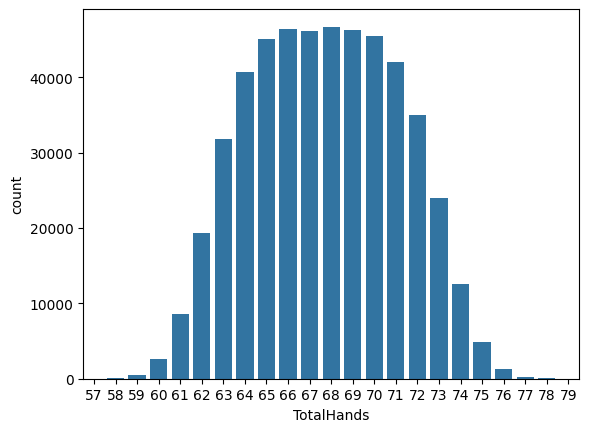

In [ ]:
# Graph of total hands/shoe.
ax = sns.countplot(x="TotalHands", data = df)

In [ ]:
# Pandas/Shoe
df.Pandas.value_counts(sort = False)

6      10061
5      27521
1     111786
2     134552
4      60821
0      45640
3     105397
8        821
7       3132
9        216
10        43
11         9
12         1
Name: Pandas, dtype: int64

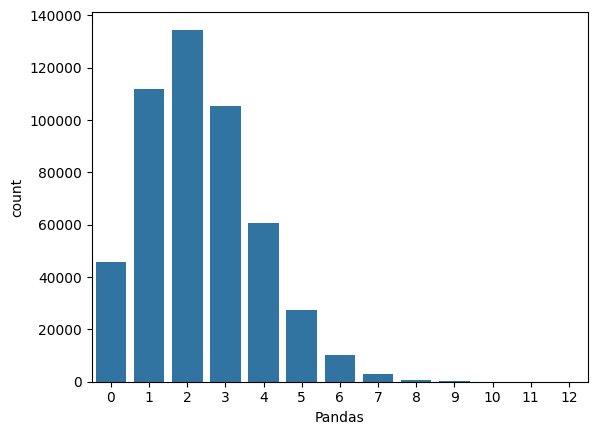

In [ ]:
ax = sns.countplot (x="Pandas", data = df)

In [ ]:
# Counts of dragons/shoe.
df.Dragon.value_counts(sort = False)

2     128476
1     167265
4      24043
3      65233
0     106073
5       6866
7        304
6       1672
8         58
9          9
10         1
Name: Dragon, dtype: int64

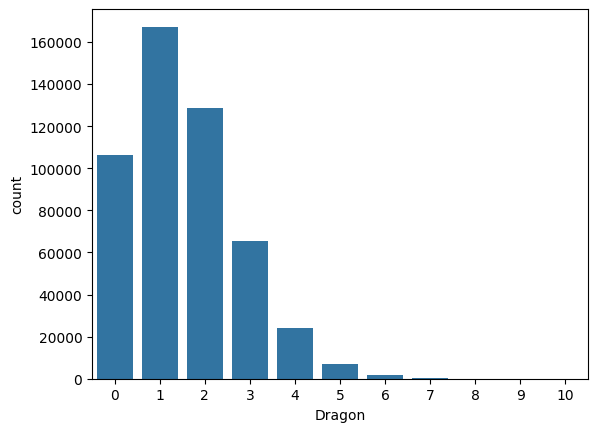

In [ ]:
ax = sns.countplot (x="Dragon", data = df)

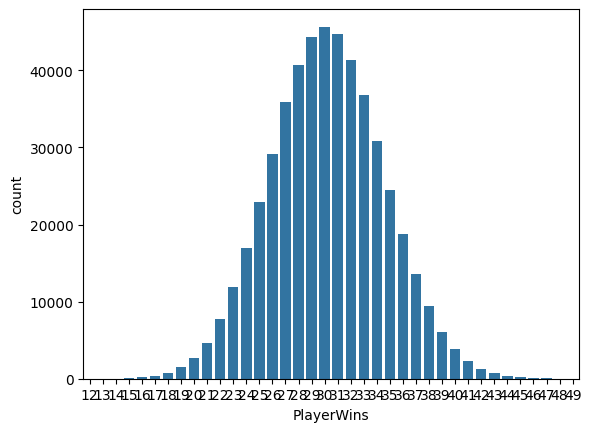

In [ ]:
ax = sns.countplot (x="PlayerWins", data = df)

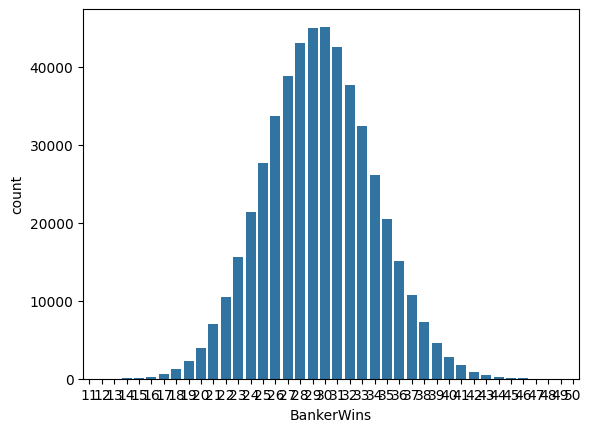

In [ ]:
ax = sns.countplot (x="BankerWins", data = df)

In [ ]:
# Total hands run.
df['TotalHands'].sum()

33848443

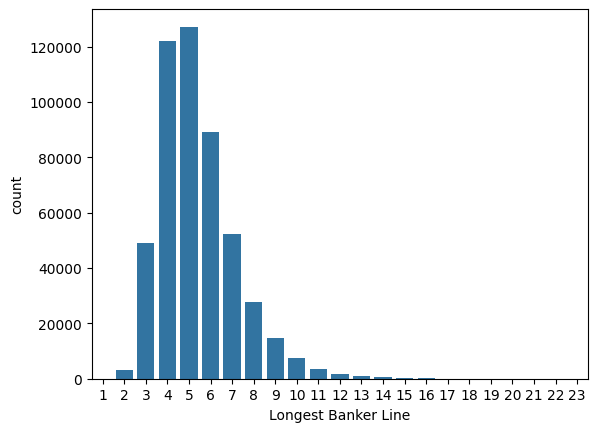

In [ ]:
ax = sns.countplot (x = "Longest Banker Line", data = df)

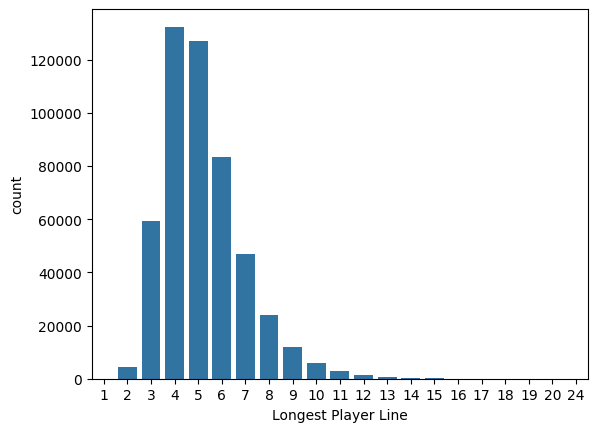

In [ ]:
ax = sns.countplot (x = "Longest Player Line", data = df)

In [ ]:
df.value_counts(subset = 'Longest Banker Line', sort = False)

Longest Banker Line
1          2
2       2990
3      48980
4     122176
5     127255
6      89326
7      52294
8      27831
9      14553
10      7318
11      3653
12      1805
13       898
14       449
15       234
16       135
17        42
18        31
19        16
20         7
21         2
22         2
23         1
dtype: int64

In [ ]:
df.value_counts(subset = 'Longest Player Line', sort = False)

Longest Player Line
1          3
2       4284
3      59265
4     132453
5     126979
6      83268
7      46776
8      23806
9      11870
10      5748
11      2860
12      1406
13       674
14       299
15       160
16        75
17        38
18        22
19        10
20         3
24         1
dtype: int64

In [ ]:
# Pandas/Shoe
df.TotalHands.value_counts(sort = False)

68    46736
60     2570
65    45120
64    40671
63    31834
66    46412
72    35018
69    46361
71    42098
70    45469
62    19384
67    46170
73    24051
61     8534
74    12514
75     4862
76     1331
77      258
59      516
58       48
78       38
57        3
79        2
Name: TotalHands, dtype: int64